In [1]:
!pip -q install torchinfo

In [2]:
!pip freeze | grep torch
!pip freeze | grep torchinfo
!pip freeze | grep tensorboard

torch @ https://download.pytorch.org/whl/cu118/torch-2.0.1%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=a7a49d459bf4862f64f7bc1a68beccf8881c2fa9f3e0569608e16ba6f85ebf7b
torchaudio @ https://download.pytorch.org/whl/cu118/torchaudio-2.0.2%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=26692645ea061a005c57ec581a2d0425210ac6ba9f923edf11cc9b0ef3a111e9
torchdata==0.6.1
torchinfo==1.8.0
torchsummary==1.5.1
torchtext==0.15.2
torchvision @ https://download.pytorch.org/whl/cu118/torchvision-0.15.2%2Bcu118-cp310-cp310-linux_x86_64.whl#sha256=19ca4ab5d6179bbe53cff79df1a855ee6533c2861ddc7389f68349d8b9f8302a
torchinfo==1.8.0
tensorboard==2.13.0
tensorboard-data-server==0.7.1


In [3]:
import numpy as np

import torch
from torch import nn
# Get CPU or GPU device
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {DEVICE} device')

from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torch.nn.functional as F

import matplotlib.pyplot as plt

import pandas as pd

from tqdm import tqdm

import time

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

Using cpu device


# Imports

In [4]:
!pip -q install kaggle
!mkdir /root/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c spaceship-titanic

  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 110MB/s]


In [7]:
!unzip -q 'spaceship-titanic.zip' -d /content/spaceship_tmp

In [8]:
train = pd.read_csv('/content/spaceship_tmp/train.csv')
test = pd.read_csv('/content/spaceship_tmp/test.csv')

train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


# Custom Dataset

In [9]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler

In [10]:
class DataConversion:

    def __init__(self, data: pd.DataFrame, test: bool = False):
        self.test = test

        data[['Deck', 'Num', 'Side']] = data['Cabin'].str.split('/', expand=True)

        if self.test:
            self.features = data.drop(['Cabin', 'Num', 'Name'], axis=1)
        else:
            self.targets = data['Transported'].replace({True: 1, False: 0})
            self.features = data.drop(['Cabin', 'Num', 'Name', 'Transported'], axis=1)

        self.features['Deck'] = self.features['Deck'].replace('T', 'G')

    @staticmethod
    def get_outliers(num_data: pd.DataFrame) -> pd.DataFrame:
        quantile_1 = num_data.quantile(0.01)
        quantile_3 = num_data.quantile(0.99)

        IQR = quantile_3 - quantile_1
        lower_cond = quantile_1 - 1.5 * IQR
        upper_cond = quantile_3 + 1.5 * IQR

        num_data = num_data[~((num_data < lower_cond) | (num_data > upper_cond))]

        return num_data

    def drop_encode(self):
        features = self.features.copy()

        num_cols = features.keys()[features.dtypes == 'float']
        features[num_cols] = SimpleImputer(strategy='median').fit_transform(features[num_cols])

        features[num_cols] = self.get_outliers(features[num_cols])
        features[num_cols] = StandardScaler().fit_transform(features[num_cols])

        cat_cols = features.keys()[features.dtypes != 'float']
        features[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(features[cat_cols])

        for key in cat_cols: features[key] = LabelEncoder().fit_transform(features[key])

        features['Shop+Food'] = features['ShoppingMall'] + features['FoodCourt']

        if not self.test:
            df = features
            df['Transported'] = self.targets

        return features.dropna() if self.test else df.dropna()

In [11]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, data: pd.DataFrame, test: bool = False):
        self.test = test
        data_obj = DataConversion(data, test=self.test)

        data = data_obj.drop_encode()
        self.indices = data["PassengerId"].astype(int)

        self.targets = None if self.test else data[["Transported"]].set_index(self.indices)

        self.data = data.set_index(self.indices).drop(["PassengerId"], axis=1) if self.test else data.set_index(self.indices).drop(["PassengerId", "Transported"], axis=1)
        self.features_cols = self.data.keys()


    @staticmethod
    def shuffle_dataset(data: pd.DataFrame) -> pd.DataFrame:
        return data.sample(frac=1)

    def __contains__(self, idx: int) -> bool:
        return True if idx in self.indices else False

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int):
        if torch.is_tensor(idx): idx = idx.tolist()
        if self.__contains__(idx): return (dict(self.data.loc[idx])) if self.test else (dict(self.data.loc[idx]), dict(self.targets.loc[idx]))

In [58]:
%%time

train_data = CustomDataset(train.copy(), test=False)

CPU times: user 95.7 ms, sys: 3 ms, total: 98.7 ms
Wall time: 103 ms


In [59]:
LEN_DATA = len(train_data.data)

TRAIN_LEN = int(0.85 * LEN_DATA)

TRAIN_LEN

7351

In [60]:
train_data.indices.sample(frac=1)[TRAIN_LEN:]

2909    2909
2891    2891
3382    3382
6779    6779
1141    1141
        ... 
1085    1085
4100    4100
286      286
7345    7345
2496    2496
Name: PassengerId, Length: 1298, dtype: int64

In [61]:
train_data.data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Side,Shop+Food
PassengerId,,,,,,,,,,,,,
0,1,0,2,0.711945,0,-0.355711,-0.295466,-0.347787,-0.290965,-0.278064,1,0,-0.643253
1,0,0,2,-0.334037,0,-0.171799,-0.289331,-0.291785,0.267179,-0.235261,5,1,-0.581117
2,1,0,2,2.036857,1,-0.283159,2.142208,-0.347787,6.535875,-0.230397,0,1,1.794422
3,1,0,2,0.293552,0,-0.355711,0.579124,0.483277,3.093480,-0.090316,0,1,1.062402
4,0,0,2,-0.891895,0,0.155532,-0.247749,-0.009537,0.283446,-0.276118,5,1,-0.257286
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,1,0,0,0.851410,1,-0.355711,4.352885,-0.347787,1.379400,-0.206078,0,0,4.005098
8689,0,1,1,-0.752431,0,-0.355711,-0.295466,-0.347787,-0.290965,-0.278064,6,1,-0.643253
8690,0,0,2,-0.194573,0,-0.355711,-0.295466,3.845614,-0.289948,-0.278064,6,1,3.550147


In [62]:
train_data.features_cols

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'Side',
       'Shop+Food'],
      dtype='object')

In [63]:
train_data.__getitem__(0)

({'HomePlanet': 1.0,
  'CryoSleep': 0.0,
  'Destination': 2.0,
  'Age': 0.7119453650967104,
  'VIP': 0.0,
  'RoomService': -0.35571114586949387,
  'FoodCourt': -0.29546639224910703,
  'ShoppingMall': -0.34778685333480236,
  'Spa': -0.29096452755373003,
  'VRDeck': -0.27806353877809287,
  'Deck': 1.0,
  'Side': 0.0,
  'Shop+Food': -0.6432532455839094},
 {'Transported': 0})

In [64]:
BATCH_SIZE = 128

class CustomSequentialSampler(torch.utils.data.Sampler):

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self) -> int:
        return len(self.indices)

In [65]:
def tensor_collate_fn(batch):
    features = dict(
        zip(
            train_data.features_cols, torch.stack([torch.as_tensor(list(item[0].values()), dtype=torch.float) for item in batch], dim=1)
        )
    )
    targets = {"Transported": torch.stack([torch.as_tensor(list(item[1].values()), dtype=torch.int64) for item in batch])}

    return features, targets

In [66]:
indices = train_data.indices.sample(frac=1)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, collate_fn=tensor_collate_fn, sampler=CustomSequentialSampler(indices[:TRAIN_LEN])
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, collate_fn=tensor_collate_fn, sampler=CustomSequentialSampler(indices[TRAIN_LEN:])
)

In [ ]:
next(iter(valid_dataloader))[0].keys()

dict_keys(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'Side', 'Shop+Food'])

# Torch model


In [146]:
INPUT_SIZE = len(train_data.__getitem__(train_data.indices[0])[0]) # num_features
HIDDEN_SIZE = 64

NUM_CLASSES = 2
EMBEDDING_DIM = 12

INPUT_SIZE

13

In [147]:
CAT_FEATURES = {col: len(train_data.data[col].unique()) for col in train_data.data.keys() if len(train_data.data[col].unique()) < 20}
NUM_FEATURES = [col for col in train_data.data.keys() if col not in CAT_FEATURES]
NUM_FEATURES, CAT_FEATURES

(['Age',
  'RoomService',
  'FoodCourt',
  'ShoppingMall',
  'Spa',
  'VRDeck',
  'Shop+Food'],
 {'HomePlanet': 3,
  'CryoSleep': 2,
  'Destination': 3,
  'VIP': 2,
  'Deck': 7,
  'Side': 2})

In [148]:
class SimpleAttention1d(nn.Module):

    def __init__(self, features_dim: int):
        super(SimpleAttention1d, self).__init__()
        self.features_dim = features_dim

        self.linear_block = nn.Sequential(
            nn.Linear(in_features=self.features_dim, out_features=self.features_dim),
            nn.BatchNorm1d(self.features_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        logits = self.linear_block(inputs)
        return torch.multiply(inputs, logits)

In [157]:
class DenseEmbModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, emb_dim: int = 10, bias: bool = True, num_layers: int = 1,
                 bidirectional: bool = False, dropout_lstm: float = 0.0, device: str = "cpu"):
        super(DenseEmbModel, self).__init__()
        self.device = device

        self.embeddings = nn.ModuleDict()
        for col, num_embs in CAT_FEATURES.items():
            self.embeddings[col] = nn.Embedding(num_embeddings=num_embs, embedding_dim=emb_dim).to(self.device)

        self.layer_norm = nn.BatchNorm1d(num_features=input_size)
        self.att_layer = SimpleAttention1d(features_dim=input_size)


        self.bidir = bidirectional
        num_directions = 2 if self.bidir else 1

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=num_layers,
            bidirectional=self.bidir,
            dropout=dropout_lstm
        ).to(self.device)

        self.out = nn.Sequential(
            nn.Linear(in_features=hidden_size * num_directions, out_features=hidden_size, bias=bias),
            nn.BatchNorm1d(num_features=hidden_size),
            nn.Dropout(p=0.3),
            nn.ReLU(),

            nn.Linear(in_features=hidden_size, out_features=hidden_size // 2, bias=bias),
            nn.BatchNorm1d(num_features=hidden_size // 2),
            nn.Dropout(p=0.2),
            nn.ReLU(),

            nn.Linear(in_features=hidden_size // 2, out_features=output_size, bias=bias)
        ).to(device)


    def forward(self, inputs: dict) -> torch.Tensor:
        x = torch.stack([inputs[col] for col in NUM_FEATURES], dim=1)

        for col in CAT_FEATURES:
            x = torch.concat([x, self.embeddings[col](torch.as_tensor(inputs[col], dtype=torch.int64))], dim=1)

        x = self.att_layer(self.layer_norm(x))


        x, _ = self.lstm(x)
        x = self.out(x)

        return x

In [175]:
model_emb_torch = DenseEmbModel(input_size=len(CAT_FEATURES) * EMBEDDING_DIM + len(NUM_FEATURES), hidden_size=HIDDEN_SIZE, output_size=NUM_CLASSES, dropout_lstm=0.5,
                                emb_dim=EMBEDDING_DIM, num_layers=2, bidirectional=True, device=DEVICE)

model_emb_torch

DenseEmbModel(
  (embeddings): ModuleDict(
    (HomePlanet): Embedding(3, 12)
    (CryoSleep): Embedding(2, 12)
    (Destination): Embedding(3, 12)
    (VIP): Embedding(2, 12)
    (Deck): Embedding(7, 12)
    (Side): Embedding(2, 12)
  )
  (layer_norm): BatchNorm1d(79, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (att_layer): SimpleAttention1d(
    (linear_block): Sequential(
      (0): Linear(in_features=79, out_features=79, bias=True)
      (1): BatchNorm1d(79, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Softmax(dim=1)
    )
  )
  (lstm): LSTM(79, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (out): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, m

In [168]:
model_emb_torch.forward(next(iter(train_dataloader))[0]).size()

torch.Size([128, 2])

# Train

In [24]:
!mkdir -p /content/train_model/

In [177]:
import time

class TrainModel:
    def __init__(self, train, valid, model, criterion, optimizer, scheduler = None, step_save: int = 100):
        self.train_data = train
        self.valid_data = valid

        self.step_save = step_save

        self.model = model
        self.criterion = criterion

        self.optimizer = optimizer
        self.scheduler = scheduler

        self.train_results = list()
        self.valid_results = list()

        #self.train_loss_writer = SummaryWriter("/content/train_model/logs/train")


    def save_model_params(self, save_epoch):
        torch.save(
            {
                "model": self.model.state_dict(),
                "optimizer": self.optimizer.state_dict(),
                "scheduler": self.scheduler.state_dict if self.scheduler is not None else {},
            }, "/content/train_model/model_state_dict_%d" % (self.step_save * (save_epoch + 1))
        )


    def valid(self, epoch):
        n_correct, sum_loss, roc_auc_mean = 0., 0., 0.

        n_total_steps = (LEN_DATA - TRAIN_LEN) // BATCH_SIZE
        dataset_size = LEN_DATA - TRAIN_LEN

        with torch.no_grad():
            for step, (inputs, labels) in enumerate(self.valid_data):
                inputs, labels  = inputs, labels["Transported"].squeeze().to(DEVICE)

                output = self.model(inputs)

                n_correct += torch.sum((output.argmax(dim=1) == labels))
                self.valid_results.append([epoch * TRAIN_LEN // BATCH_SIZE + step, self.criterion(output, labels).item(), roc_auc_score(labels, output.argmax(dim=1).detach().numpy())])

            print(f'{"-" * 60}\n{" " * 10}Accuracy/valid: {(n_correct.float() / dataset_size):.4f}\n{"-" *60}')


    def fit(self, epochs: int = 3, scheduler_step: int = 100, show_step: int = 100):
        n_total_steps = TRAIN_LEN // BATCH_SIZE
        dataset_size = TRAIN_LEN

        save_epoch = 0

        for epoch in range(epochs):
            epoch_start_time = time.time()
            print('Epoch %s/%s' % (epoch + 1, epochs))

            n_correct = 0

            for step, (inputs, labels) in enumerate(self.train_data):
                self.optimizer.zero_grad()

                inputs, labels  = inputs, labels["Transported"].squeeze().to(DEVICE)

                output = self.model(inputs)
                n_correct += torch.sum((output.argmax(dim=1) == labels))
                loss = self.criterion(output, labels)

                loss.backward()
                self.optimizer.step()

                self.train_results.append([epoch * n_total_steps + step, loss.item(), roc_auc_score(labels, output.argmax(dim=1).detach().numpy()), self.optimizer.param_groups[0]["lr"]])

                #self.train_loss_writer.add_scalar('training_loss', loss.item(), step)

                if (step+1) % show_step == 0:
                    print(f'Step [{step+1}/{n_total_steps}] | Time: {time.time() - epoch_start_time:.2f}s |  Loss: {loss.item():.4f}')

                if (self.scheduler is not None) and (step % scheduler_step == 0): self.scheduler.step()

                if (epoch * n_total_steps + step) % self.step_save == 0:
                    self.save_model_params(save_epoch)
                    save_epoch += 1

            print(f'{"-" * 60}\n{" " * 10}Accuracy/train: {(n_correct.float() / dataset_size):.4f}\n{"-" *60}')
            self.valid(epoch)

        self.train_writer = pd.DataFrame(self.train_results, columns=["step", "loss", "roc_auc_score", "lr_value"])
        self.valid_writer = pd.DataFrame(self.valid_results, columns=["step", "loss", "roc_auc_score"])
        print('\nDone.')


    def __repr__(self):
        return f'''[INFO]\n{"-" * 60}\ndata: {self.data} \n{"-" * 60} \nmodel: {self.model} \n{"-" * 60}
                    criterion: {self.criterion} \n{"-" * 60} \noptimizer: {self.optimizer} \n{"-" * 60}'''

In [178]:
opt = torch.optim.NAdam(model_emb_torch.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

train_model = TrainModel(
    train=train_dataloader, valid=valid_dataloader, model=model_emb_torch, criterion=nn.CrossEntropyLoss(), optimizer=opt, scheduler=scheduler, step_save=200
)
train_model.fit(epochs=15, scheduler_step=len(train_dataloader), show_step=15)

Epoch 1/15
Step [15/57] | Time: 0.72s |  Loss: 0.7170
Step [30/57] | Time: 1.42s |  Loss: 0.6912
Step [45/57] | Time: 2.09s |  Loss: 0.7078
------------------------------------------------------------
          Accuracy/train: 0.5231
------------------------------------------------------------
------------------------------------------------------------
          Accuracy/valid: 0.5655
------------------------------------------------------------
Epoch 2/15
Step [15/57] | Time: 1.08s |  Loss: 0.6756
Step [30/57] | Time: 2.16s |  Loss: 0.5870
Step [45/57] | Time: 3.25s |  Loss: 0.6294
------------------------------------------------------------
          Accuracy/train: 0.6602
------------------------------------------------------------
------------------------------------------------------------
          Accuracy/valid: 0.7126
------------------------------------------------------------
Epoch 3/15
Step [15/57] | Time: 0.65s |  Loss: 0.5806
Step [30/57] | Time: 1.33s |  Loss: 0.4712
Ste

In [124]:
#!rm -r -f /content/train_model
#!mkdir -p /content/train_model

In [179]:
!ls /content/train_model

model_state_dict_1000  model_state_dict_400  model_state_dict_800
model_state_dict_200   model_state_dict_600


In [180]:
train_model.valid_writer

,step,loss,roc_auc_score
0,0,0.671337,0.553968
1,1,0.670190,0.529484
2,2,0.698374,0.490965
3,3,0.647831,0.604412
4,4,0.690114,0.610323
...,...,...,...
160,810,0.402158,0.812500
161,811,0.432789,0.805172
162,812,0.531817,0.757937
163,813,0.508061,0.732322


In [181]:
train_model.train_writer

,step,loss,roc_auc_score,lr_value
0,0,0.722709,0.503212,0.00100
1,1,0.778491,0.491475,0.00099
2,2,0.766640,0.513793,0.00099
3,3,0.759980,0.488989,0.00099
4,4,0.762640,0.440910,0.00099
...,...,...,...,...
865,851,0.435709,0.803763,0.00086
866,852,0.335500,0.843956,0.00086
867,853,0.368799,0.843468,0.00086
868,854,0.386719,0.803156,0.00086


In [182]:
model_training_values = train_model.train_writer
model_valid_values = train_model.valid_writer

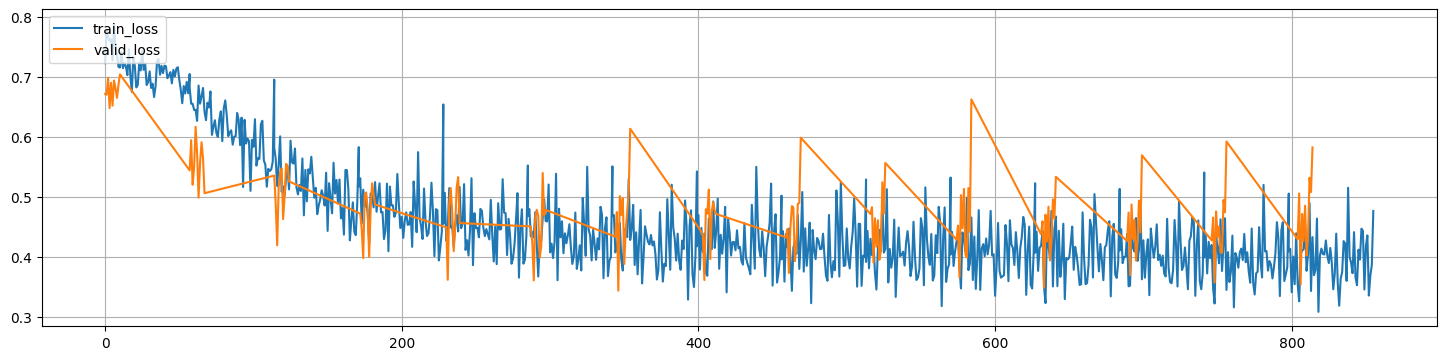

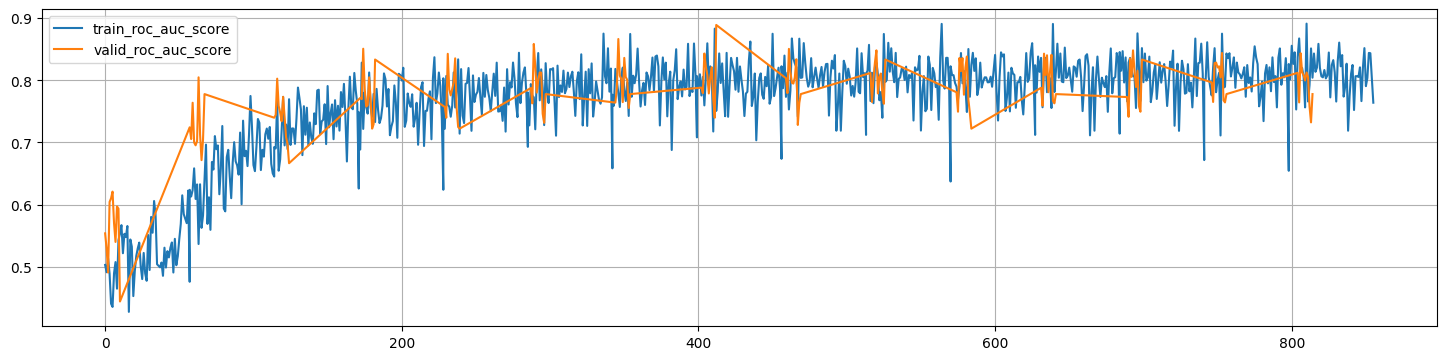

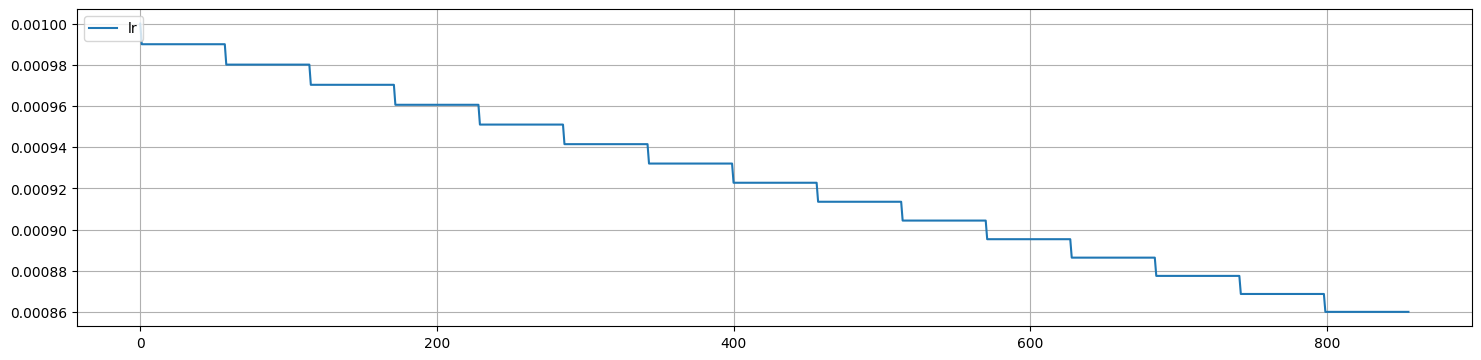

In [183]:
plt.figure(figsize=(18, 14)).add_subplot(3, 1, 1)
plt.grid()
plt.plot(model_training_values["step"], model_training_values["loss"], label="train_loss")
plt.plot(model_valid_values["step"], model_valid_values["loss"], label="valid_loss")
plt.legend(loc=2)

plt.figure(figsize=(18, 14)).add_subplot(3, 1, 2)
plt.grid()
plt.plot(model_training_values["step"], model_training_values["roc_auc_score"], label="train_roc_auc_score")
plt.plot(model_valid_values["step"], model_valid_values["roc_auc_score"], label="valid_roc_auc_score")
plt.legend(loc=2)

plt.figure(figsize=(18, 14)).add_subplot(3, 1, 3)
plt.grid()
plt.plot(model_training_values["step"], model_training_values["lr_value"], label="lr")
plt.legend(loc=2)

# Scoring

In [184]:
def scoring(data, model, test: bool = False):
    with torch.no_grad():
        scores = []
        true_labels = []

        if test:
            for inputs in tqdm(data, desc='Scoring data...', ncols=80):
                output = model(inputs)
                scores.append(output)
        else:
            for (inputs, labels) in tqdm(data, desc='Scoring data...', ncols=80):
                labels = labels["Transported"].squeeze().to(DEVICE)

                output = model(inputs)

                scores.append(output)
                true_labels.append(labels)

        scores = torch.concatenate(scores)
        if not test: true_labels = torch.concatenate(true_labels)

        return pd.DataFrame(scores.detach().cpu()) if test else (pd.DataFrame(scores.detach().cpu()), true_labels)

In [185]:
def accuracy(y_true, probas):
    pred = []
    print('Compute accuracy... ')
    for score in probas.values:
        for key, value in dict(enumerate(score)).items():
            if score.max() == value: pred.append(key)

    n_correct = 0
    for index, value in enumerate(pred):
        if value == y_true[index].cpu().numpy(): n_correct += 1

    return n_correct / len(y_true)

In [186]:
test_data = CustomDataset(test.copy(), test=True)
test_data.data

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Deck,Side,Shop+Food
PassengerId,,,,,,,,,,,,,
0,0,1,2,-0.114147,0,-0.372440,-0.302025,-0.340179,-0.287303,-0.272034,6,1,-0.642204
1,0,0,2,-0.684313,0,-0.372440,-0.295362,-0.340179,2.632961,-0.272034,5,1,-0.635541
2,1,1,0,0.170937,0,-0.372440,-0.302025,-0.340179,-0.287303,-0.272034,2,1,-0.642204
3,1,0,2,0.669832,0,-0.372440,4.622172,-0.340179,-0.100067,0.303053,2,1,4.281993
4,0,0,2,-0.613042,0,-0.354766,-0.302025,0.987321,-0.287303,-0.272034,5,1,0.685296
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0,1,2,0.384749,0,-0.372440,-0.302025,-0.340179,-0.287303,-0.272034,6,1,-0.642204
4273,0,0,2,0.954916,0,-0.372440,0.324974,-0.304639,-0.276959,-0.130474,5,1,0.020334
4274,2,1,0,-0.185417,0,-0.372440,-0.302025,-0.340179,-0.287303,-0.272034,3,0,-0.642204


In [187]:
def custom_test_collate_fn(batch):
    return dict(
        zip(
            test_data.features_cols, torch.stack([torch.as_tensor(list(item.values()), dtype=torch.float) for item in batch], dim=1)
        )
    )

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=BATCH_SIZE, collate_fn=custom_test_collate_fn, sampler=CustomSequentialSampler(test_data.indices)
)

In [188]:
train_scores, true_labels = scoring(train_dataloader, model_emb_torch)
valid_scores, true_labels_valid = scoring(valid_dataloader, model_emb_torch)
test_scores = scoring(test_dataloader, model_emb_torch, test=True)

Scoring data...: 100%|██████████████████████████| 34/34 [00:00<00:00, 38.80it/s]


In [191]:
print('Accuracy on train: %.4f \n' % accuracy(true_labels, train_scores))
print('Accuracy on valid: %.4f \n' % accuracy(true_labels_valid, valid_scores))

Compute accuracy... 
Accuracy on train: 0.8183 

Compute accuracy... 
Accuracy on valid: 0.7966 



# Calibration

In [192]:
class ProbaDataset(torch.utils.data.Dataset):
    def __init__(self, proba: pd.DataFrame, targets: torch.Tensor = None, test: bool = False):
        assert type(proba) is pd.DataFrame, 'not pandas dataframe'
        self.test = test

        self.proba = proba
        if not self.test: self.targets = pd.DataFrame(targets)

        self.indices = self.proba.index

    def __contains__(self, idx):
        return True if idx in self.indices else False

    def __len__(self):
        return len(self.proba)

    def __getitem__(self, idx):
        if self.__contains__(idx):
            return  self.proba.loc[idx].values if self.test else (self.proba.loc[idx].values, self.targets.loc[idx].values)

In [194]:
proba_custom_dataset_train = ProbaDataset(train_scores, true_labels)
proba_custom_dataset_valid = ProbaDataset(valid_scores, true_labels_valid)

proba_custom_dataset_train.__getitem__(0)

(array([ 0.09499377, -0.36498922], dtype=float32), array([1]))

In [196]:
proba_custom_dataset_test = ProbaDataset(test_scores, test=True)
proba_custom_dataset_test.__getitem__(0)

array([-0.43369308,  0.420218  ], dtype=float32)

In [197]:
proba_dataloader_train = torch.utils.data.DataLoader(
    dataset=proba_custom_dataset_train, batch_size=BATCH_SIZE
)

proba_dataloader_valid = torch.utils.data.DataLoader(
    dataset=proba_custom_dataset_valid, batch_size=BATCH_SIZE
)

proba_dataloader_test = torch.utils.data.DataLoader(
    dataset=proba_custom_dataset_test, batch_size=BATCH_SIZE
)

In [198]:
class LogReg(nn.Module):
    __constants__ = ['in_features']
    weights: torch.Tensor

    def __init__(self, in_features: int, bias: bool = True, device: str = 'cpu', **kwargs) -> None:
        super(LogReg, self).__init__(**kwargs)
        self.device = device

        self.use_bias = bias

        stdv = 1. / torch.math.sqrt(in_features)
        self.weights = nn.Parameter(data=torch.empty(size=(1, in_features), dtype=torch.float), requires_grad=True)
        self.weights.data.uniform_(-stdv, stdv)

        if self.use_bias:
            self.bias = nn.Parameter(data=torch.empty(size=(1, 1), dtype=torch.float), requires_grad=True)
            self.bias.data.uniform_(-stdv, stdv)

        self.sigmoid = nn.Sigmoid()


    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        if self.use_bias: return self.sigmoid(torch.matmul(inputs.to(self.device), torch.transpose(self.weights, dim0=0, dim1=1)) + self.bias.squeeze())
        else: return self.sigmoid(torch.matmul(inputs.to(self.device), torch.transpose(self.weights, dim0=0, dim1=1)))

In [199]:
model_logreg = LogReg(in_features=train_scores.shape[-1], device=DEVICE)
model_logreg

LogReg(
  (sigmoid): Sigmoid()
)

In [201]:
import time

class CalibrationModel:
    def __init__(self, train, valid, model, criterion, optimizer, scheduler = None):
        self.train_data = train
        self.valid_data = valid
        self.model = model
        self.criterion = criterion

        self.optimizer = optimizer
        self.scheduler = scheduler


    def valid(self):
        n_correct = 0.

        dataset_size = len(self.valid_data.dataset)

        with torch.no_grad():
            for step, (inputs, labels) in enumerate(self.valid_data):
                inputs, labels  = inputs.float(), labels.to(DEVICE)

                output = self.model(inputs)
                n_correct += torch.sum((output.round() == labels))

            print(f'{"-" * 60}\n{" " * 10}Accuracy/valid: {(n_correct.float() / dataset_size):.4f}\n{"-" *60}')


    def fit(self, epochs: int = 3, scheduler_step: int = 100, show_step: int = 100):
        n_total_steps = len(self.train_data)
        dataset_size = len(self.train_data.dataset)

        for epoch in range(epochs):
            epoch_start_time = time.time()
            print('Epoch %s/%s' % (epoch + 1, epochs))

            n_correct = 0

            for step, (inputs, labels) in enumerate(self.train_data):
                self.optimizer.zero_grad()

                inputs, labels  = inputs.float(), labels.to(DEVICE)

                output = self.model(inputs)
                n_correct += torch.sum((output.round() == labels))
                loss = self.criterion(output, torch.as_tensor(labels, dtype=torch.float))

                loss.backward()
                self.optimizer.step()

                if (step+1) % show_step == 0:
                    print(f'Step [{step+1}/{n_total_steps}] | Time: {time.time() - epoch_start_time:.2f}s |  Loss: {loss.item():.4f}')

                if (self.scheduler is not None) and (step % scheduler_step == 0): self.scheduler.step()

            print(f'{"-" * 60}\n{" " * 10}Accuracy: {(n_correct.float() / dataset_size):.4f}\n{"-" *60}')
            self.valid()

        print('\nDone.')

    def __repr__(self):
        return f'''[INFO]\n{"-" * 60}\ndata: {self.data} \n{"-" * 60} \nmodel: {self.model} \n{"-" * 60}
                    criterion: {self.criterion} \n{"-" * 60} \noptimizer: {self.optimizer} \n{"-" * 60}'''

In [202]:
opt = torch.optim.NAdam(model_logreg.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)

calibration_model = CalibrationModel(train=proba_dataloader_train, valid=proba_dataloader_valid, model=model_logreg, criterion=nn.BCELoss(), optimizer=opt, scheduler=scheduler)

calibration_model.fit(epochs=15, scheduler_step=len(proba_dataloader_train), show_step=15)

Epoch 1/15
Step [15/58] | Time: 0.19s |  Loss: 0.7561
Step [30/58] | Time: 0.37s |  Loss: 0.6154
Step [45/58] | Time: 0.55s |  Loss: 0.5643
------------------------------------------------------------
          Accuracy: 0.6308
------------------------------------------------------------
------------------------------------------------------------
          Accuracy/valid: 0.7666
------------------------------------------------------------
Epoch 2/15
Step [15/58] | Time: 0.18s |  Loss: 0.5317
Step [30/58] | Time: 0.36s |  Loss: 0.4613
Step [45/58] | Time: 0.53s |  Loss: 0.4800
------------------------------------------------------------
          Accuracy: 0.8115
------------------------------------------------------------
------------------------------------------------------------
          Accuracy/valid: 0.7866
------------------------------------------------------------
Epoch 3/15
Step [15/58] | Time: 0.17s |  Loss: 0.4941
Step [30/58] | Time: 0.36s |  Loss: 0.4186
Step [45/58] | 

# Scoring after calibration

In [208]:
def scoring_logreg(data, model, test: bool = False):
    with torch.no_grad():
        scores = []
        true_labels = []

        if test:
            for inputs in tqdm(data, desc='Scoring data...', ncols=80):
                output = model(inputs.float())
                scores.append(output)
        else:
            for (inputs, labels) in tqdm(data, desc='Scoring data...', ncols=80):
                labels = labels.squeeze().to(DEVICE)

                output = model(inputs.float())

                scores.append(output)
                true_labels.append(labels)

        scores = torch.concatenate(scores)
        if not test: true_labels = torch.concatenate(true_labels)

        return pd.DataFrame(scores.detach().cpu()) if test else (pd.DataFrame(scores.detach().cpu()), true_labels)

In [204]:
def roc_curve(y_true, probas, class_weight = None):
    assert len(np.unique(y_true)) == 2, 'roc_auc for binary, sorry :('
    assert len(y_true) == len(probas), 'y_true and probas must have the same length'

    sorted_indices = np.argsort(probas)[::-1]

    y_true_sort, probas_sort = y_true[sorted_indices], probas[sorted_indices]

    num_positive = np.sum(y_true == 1)
    num_negative = np.sum(y_true == 0)

    class_weight = class_weight if class_weight is not None else num_negative / num_positive
    weights = np.where(y_true == 1, class_weight, 1.0)[sorted_indices]

    tp, fp = 0, 0
    tpr_values, fpr_values = [], []

    for i, label in enumerate(y_true_sort):
        if label == 1: tp += weights[i]
        else: fp += weights[i]

        tpr = tp / (num_positive * class_weight)
        fpr = fp / num_negative
        tpr_values.append(tpr)
        fpr_values.append(fpr)

    return tpr_values, fpr_values

In [209]:
train_calib_proba, true_labels = scoring_logreg(proba_dataloader_train, model_logreg)
valid_calib_proba, true_labels_valid = scoring_logreg(proba_dataloader_valid, model_logreg)
test_calib_proba = scoring_logreg(proba_dataloader_test, model_logreg, test=True)

Scoring data...: 100%|█████████████████████████| 34/34 [00:00<00:00, 180.34it/s]


In [210]:
train_calib_proba.mean(), valid_calib_proba.mean(), test_calib_proba.mean()

(0    0.499358
 dtype: float32,
 0    0.492073
 dtype: float32,
 0    0.501554
 dtype: float32)

In [211]:
tpr_train, fpr_train = roc_curve(true_labels.numpy(), train_calib_proba.values.ravel())
tpr_valid, fpr_valid = roc_curve(true_labels_valid.numpy(), valid_calib_proba.values.ravel())

roc_auc_score train: 0.9042
roc_auc_score valid: 0.8709

accuracy_train: 0.8183
accuracy_train: 0.7951



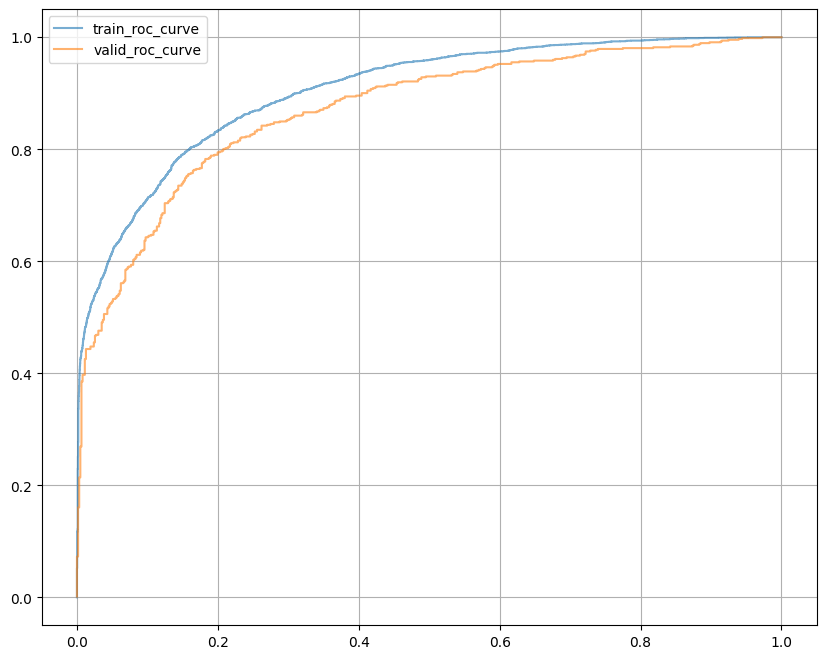

In [216]:
ax = plt.figure(figsize=(10, 8)).add_subplot()
print("roc_auc_score train: %.4f" % np.trapz(tpr_train, fpr_train))
print("roc_auc_score valid: %.4f\n" % np.trapz(tpr_valid, fpr_valid))

print("accuracy_train: %.4f" % (torch.sum(torch.from_numpy(train_calib_proba.values.ravel()).round() == true_labels) / len(true_labels)).numpy())
print("accuracy_train: %.4f\n" % (torch.sum(torch.from_numpy(valid_calib_proba.values.ravel()).round() == true_labels_valid) / len(true_labels_valid)).numpy())

ax.plot(fpr_train, tpr_train, alpha=0.6, label='train_roc_curve')
ax.plot(fpr_valid, tpr_valid, alpha=0.6, label='valid_roc_curve')
ax.grid()
ax.legend(loc=2)
plt.show()